# Visualize Air Pollution in Bangkok

# Background

Air pollution is a pollution threat in many Asian countries. Being informed about the current outdoor air quality helps you protect yourself. Recently, Thai people become more concern about local air pollution due to the high level of pollution in Bangkok in winter of 2019. Air polution is reported as air quality index (AQI). The high AQI mean bad air pollution. The major pollutant was the small size particle pollution (PM2.5). Still there are a lot of misconceptions and debates about the causes of the pollution and degree of hazard of particles. 

This notebook tried a way to answer answer some of the questions about air pollution through data visualization. Moreover, it includes how to generate these vizs are generated so that the same method can be applied to your local air quality measurement. I was inspired by the work from  a Facebook post by [Data-addict](https://scontent-sjc3-1.xx.fbcdn.net/v/t1.0-9/34398114_426447444494150_7618108699801812992_n.png?_nc_cat=108&_nc_ht=scontent-sjc3-1.xx&oh=0ac2b42de652b994d8f1994ecb835418&oe=5CF14B7F)

In [5]:
import sys
sys.path.append(r'C:\Users\Benny\fastai\old')
from pathlib import Path
from fastai.imports import *
import seaborn as sns

import statsmodels.api as sm
import datetime 
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

# Import Data

Import googld trend data and PM2.5 data.

In [57]:
trend_aqi = pd.read_csv('data/google_trend_aqi.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','aqi_trend'])
trend_pm25 = pd.read_csv('data/google_trend_pm25.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','pm25_trend'])

trend = trend_aqi.merge(trend_pm25, on=['date'], how ='outer')

In [58]:
trend.head()

,date,aqi_trend,pm25_trend
0,2014-02-23,0,<1
1,2014-03-02,<1,<1
2,2014-03-09,1,0
3,2014-03-16,1,<1
4,2014-03-23,1,<1


In [59]:
trend.tail()

,date,aqi_trend,pm25_trend
256,2019-01-20,61,40
257,2019-01-27,100,100
258,2019-02-03,58,49
259,2019-02-10,38,26
260,2019-02-17,32,15


In [60]:
trend['date'] =  pd.to_datetime(trend['date'],yearfirst=True)


In [61]:
trend['aqi_trend'] = trend['aqi_trend'].str.replace('<1','0')
trend['pm25_trend'] = trend['pm25_trend'].str.replace('<1','0')


In [62]:
trend[['aqi_trend', 'pm25_trend']] = trend[[
    'aqi_trend', 'pm25_trend']].astype(np.int32)

In [86]:
trend.to_csv('data/google_trend_all.csv',index=False)

In [55]:
trend = pd.read_csv('data/google_trend_all.csv',infer_datetime_format=True)
trend['date'] = pd.to_datetime(trend['date'])

As mentioned above, more people are aware of the air pollution problem, how do I know that ? There are surge of Google search for the words 'PM2.5' and 'AQI' in Thailand around 2019. 

Text(0.5, 1.0, 'Google Search Frequency in Thailand')

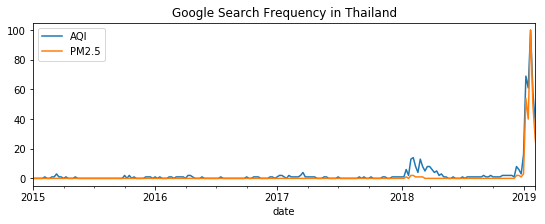

In [261]:
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI','PM2.5'], xlim=['2015-01-01', '2019-02-07'],
          figsize=(9,3))
plt.title('Google Search Frequency in Thailand')

How AQI are calculated? That depends on the law in different countries. They mostly divided into four pollutants source: ground level ozone(O3), particle pollution (PM2.5 and PM10), toxic gas (NO2, CO, SO2). The table below shows different pollutants from various stations in Thailand on February 2, 2019. There are level of CO, NO2, O3, SO2, PM10 and PM2.5. Most level are normal except, high level of PM2.5 in some region. 

PM2.5 are particle of size smaller than 2.5 micron. PM2.5 concentation higher than 35 ug/m3 is considered moderate and unhealthy for sensitive group with AQI 100 and above 55.4 ug/m3 is consider unhealthy with AQI 150. Since AQI is calculated from the highest level of pollutant aveage over 24 hours([1](https://airnow.gov/index.cfm?action=aqi_brochure.index)), we focus this notebook on PM 2.5 data. 

What cause high air pollution in Bangkok last winter? The sources of PM2.5 particle can be car engine, power plants, and agricultural waste burning. There are number of theories: still wind, old diesel cars, near by power plants, and agricultural burning from other provinces. Let's try to answer some of these questions through visualization. 

![AQI report Thailand](data/aqi_2019_02_19.png)

The government official website only provides a month historical data. I use the PM 2.5 from Berkeley Earth [website](http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/). Detail about how to use Python to scrap this data can be found in this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-PM25.ipynb). Also if you are interested in scrapping the data from the government website, you may find this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-AQI.ipynb) useful.

In [255]:
# inspecting the top of the files 
with open('data/Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

% Country: Thailand

% City: Bangkok

% City (ASCII): Bangkok

% Region: Bangkok

% Region (ASCII): Bangkok

% Population: 5104476

% Latitude: 13.754

% Longitude: 100.5014

% Time Zone: Asia/Bangkok

% Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective

2016	3	3	8	62.9	1.00	0

2016	3	3	9	62.9	1.00	0



In [116]:
pm25 = pd.read_csv('data/Bangkok.txt', sep='\t', 
                   header=None, skiprows=10)

In [117]:
pm25.head()

,0,1,2,3,4,5,6
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0


In [118]:
#assemble datetime column 
pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})

In [119]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24153 entries, 0 to 24152
Data columns (total 8 columns):
0       24153 non-null int64
1       24153 non-null int64
2       24153 non-null int64
3       24153 non-null int64
4       24153 non-null float64
5       24153 non-null float64
6       24153 non-null int64
Time    24153 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 1.5 MB


In [120]:
#convert time zone
pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
pm25['Time'] = pm25['Time'].dt.tz_localize(None)

In [121]:
pm25.head()

,0,1,2,3,4,5,6,Time
0,2016,3,3,8,62.9,1.0,0,2016-03-03 15:00:00
1,2016,3,3,9,62.9,1.0,0,2016-03-03 16:00:00
2,2016,3,3,10,55.5,1.0,0,2016-03-03 17:00:00
3,2016,3,3,11,55.5,1.0,0,2016-03-03 18:00:00
4,2016,3,3,12,47.9,1.0,0,2016-03-03 19:00:00


In [122]:
pm25=pm25.drop([0,1,2,3,5,6],axis=1)

In [123]:
pm25.columns = ['PM2.5', 'Time']
pm25[['Time','PM2.5']].to_csv('data/bkk_pm25.csv',index=False)

# Explore Data and Feature Engineers

Data preparation steps such as adding the year, day of month, day of week and the average particle levels. 

In [124]:
bkk = pd.read_csv('data/bkk_pm25.csv')
bkk['Time'] = pd.to_datetime(bkk['Time'])
bkk.head()

,Time,PM2.5
0,2016-03-03 15:00:00,62.9
1,2016-03-03 16:00:00,62.9
2,2016-03-03 17:00:00,55.5
3,2016-03-03 18:00:00,55.5
4,2016-03-03 19:00:00,47.9


In [600]:
bkk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 2 columns):
Time     23667 non-null datetime64[ns]
PM2.5    23667 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 369.9 KB


In [125]:
# rolling average over 24 hours window
bkk['PM2.5avg'] = bkk['PM2.5'].rolling(24).mean()
bkk = bkk.dropna()

In [126]:
pm25 = bkk.set_index('Time')

In [128]:
# featuare engineering 
pm25['Year'] = pm25.index.year
pm25['Month'] = pm25.index.strftime('%B')
pm25['DayofMonth'] = pm25.index.day
pm25['DayofWeek'] = pm25.index.strftime('%A')
pm25['TimeofDay'] = pm25.index.time
pm25['level'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
pm25['color'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])

In [129]:
pm25.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color
Time,,,,,,,,,
2016-03-04 15:00:00,34.2,43.520833,2016,March,4,Friday,15:00:00,moderate,orange
2016-03-04 16:00:00,35.0,42.358333,2016,March,4,Friday,16:00:00,moderate,orange
2016-03-04 17:00:00,30.0,40.987500,2016,March,4,Friday,17:00:00,moderate,orange
2016-03-04 18:00:00,25.6,39.741667,2016,March,4,Friday,18:00:00,moderate,orange
2016-03-04 19:00:00,32.1,38.766667,2016,March,4,Friday,19:00:00,moderate,orange


In [130]:
pm25.to_csv('data/bkk_pm25_proc.csv')

#  Data Visualization

Try to answer questions about air pollution in Bangkok through visualization 
* Is the problem getting worse?
* Which months have the highest level of PM2.5 in Bangkok? 
* What time has the highest pollution?
* Is the pollution lower during the holiday?

In [131]:
pm25 = pd.read_csv('data/bkk_pm25_proc.csv')
pm25['Time'] = pd.to_datetime(pm25['Time'])
pm25 = pm25.set_index('Time')
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24130 entries, 2016-03-04 15:00:00 to 2019-03-07 04:00:00
Data columns (total 9 columns):
PM2.5         24130 non-null float64
PM2.5avg      24130 non-null float64
Year          24130 non-null int64
Month         24130 non-null object
DayofMonth    24130 non-null int64
DayofWeek     24130 non-null object
TimeofDay     24130 non-null object
level         24130 non-null object
color         24130 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 1.8+ MB


In [3]:
pm25.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level
Time,,,,,,,,
2016-03-04 15:00:00,34.2,43.520833,2016,March,4,Friday,15:00:00,moderate
2016-03-04 16:00:00,35.0,42.358333,2016,March,4,Friday,16:00:00,moderate
2016-03-04 17:00:00,30.0,40.987500,2016,March,4,Friday,17:00:00,moderate
2016-03-04 18:00:00,25.6,39.741667,2016,March,4,Friday,18:00:00,moderate
2016-03-04 19:00:00,32.1,38.766667,2016,March,4,Friday,19:00:00,moderate


Pplot the particle pollution vs time.

In [289]:
pm25['level'].unique().astype(str)

array(['moderate', 'satisfactory', 'unhealthy'], dtype='<U12')

In [286]:
temp = pm25.query('level == "moderate"')
temp['level'].unique().astype(str)

array(['moderate'], dtype='<U8')

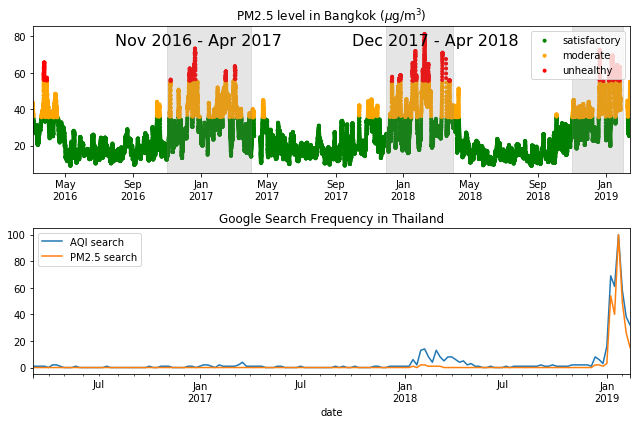

In [65]:
#color_dict = {'satisfactory':'green', 'moderate':'orange', 'unhealthy':'red'}
#pm25['color'] = [color_dict[level] for level in pm25['level']]

fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)

for legend in ['satisfactory', 'moderate', 'unhealthy']:
    temp = pm25[pm25['level']==legend]
    ax1.scatter(temp.index, temp['PM2.5avg'], 
                c=temp['color'], marker='.', label=legend)

plt.title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")
plt.legend(loc='upper right')
#plt.legend(['satisfactory', 'unhealthy for \nsensitive group', 'unhealthy'], loc='upper right')


ax1.axvspan('2016-11','2017-04', color='gray', alpha=0.2)
#ax1.annotate('',xy = ('2016-11',70), xytext=('2017-04',70),
#            arrowprops=dict(arrowstyle='<->', lw = 2))
plt.text('2017-01', 75, r'Nov 2016 - Apr 2017 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'center'})

ax1.axvspan('2017-12','2018-04', color='gray', alpha=0.2)
#ax1.annotate('',xy = ('2017-11',70), xytext=('2018-04',70),
#            arrowprops=dict(arrowstyle='<->', lw = 2))
plt.text('2017-10', 75, r'Dec 2017 - Apr 2018 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'left'})

ax1.axvspan('2018-11','2019-02', color='gray', alpha=0.2)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xlim(pm25.index.min(), pm25.index.max())

ax2 = fig.add_subplot(212)
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI search', 'PM2.5 search'], ax=ax2)
plt.title('Google Search Frequency in Thailand')
#ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xlim(pm25.index.min(), pm25.index.max())
plt.tight_layout()

The air pollution seem to be seasonal, with surge around winter seasion (Dec - Jan). In fact, the winter pollution exists since 2017, but public awareness has just increased recently.

Is the problem getting worse every year?

In [66]:
num_days = pd.DataFrame()
# number of day per year with particle lever higher than limit (AQI 150)
num_days['unhealthy'] = pm25[pm25['PM2.5avg'] > 55.4].resample('d').mean().groupby('Year').count()['DayofMonth']

# number of day per year with particle lever higher than limit (AQI 100)
num_days['moderate'] = pm25[pm25['PM2.5avg'] > 35.4].resample('d').mean().groupby('Year').count()['DayofMonth'] - num_days['unhealthy']
num_days.index = num_days.index.astype(int)

Text(0.5, 1.0, 'numbers of bad air days')

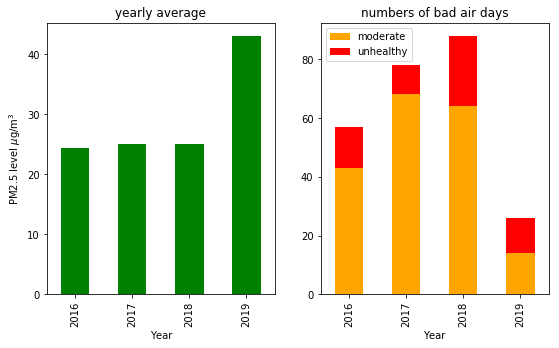

In [75]:
fig, ax = plt.subplots(1,2,figsize=(9,5))

# find yearly PM2.5 average
yearavg = pm25.groupby('Year').mean()['PM2.5avg']

yearavg.plot(kind='bar', color ='green',ax=ax[0])
ax[0].set_ylabel('PM2.5 level $\mu$g/m$^3$')
ax[0].set_title('yearly average')

num_days[['moderate','unhealthy']].plot(kind='bar', stacked=True, color = ['orange','red'], ax=ax[1])
ax[1].set_title('numbers of bad air days')

In [71]:
print(yearavg)

Year
2016    24.376378
2017    25.117491
2018    25.037562
2019    43.118296
Name: PM2.5avg, dtype: float64


The average for 2019 is high because we only have the winter data, which has high pollution.This set of data does not have data in Jan-Feb of 2016, and 2015, which explain why the number of day is lower in 2016. The year 2018 has 25 days with very high AQI (from the Jan-Feb and Dec). Without more data, it's hard to judge if the situation is getting worse. 

To summarize, the yearly average is not increasing, but the number of days with high AQI seem to be higher. Another way to see trend for time series data is to look at the rate of change, which is shown below. 

(array([736420., 736511., 736603., 736695., 736785., 736876., 736968., 737060.]),
 <a list of 8 Text xticklabel objects>)

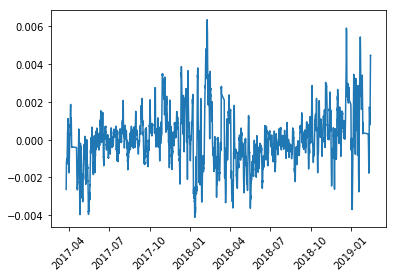

In [588]:
plt.plot(pm25['PM2.5avg'].diff().rolling(24*30*12).mean())
plt.xticks(rotation=45)

The rate of change is around zero except at the very end. This confirm that the problem is about the same every year. 

Bangkok is a tourist city, which month should you avoid going to Bangkok. If you are Bangkokians what is the best time to go for a jog? Is the air pollution better during the holiday when everyone is away?

I am going to perform analysis for 2017 and 2018. First, separate a table for 2017 and 2018, and then create a daily average for each date of month. 

In [136]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23644 entries, 2016-03-04 15:00:00 to 2019-02-14 03:00:00
Data columns (total 9 columns):
PM2.5         23644 non-null float64
PM2.5avg      23644 non-null float64
Year          23644 non-null int64
Month         23644 non-null object
DayofMonth    23644 non-null int64
DayofWeek     23644 non-null object
TimeofDay     23644 non-null object
level         23644 non-null object
color         23644 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 2.4+ MB


In [77]:
pm25_2017 = pm25['2017']
pm25_2018 = pm25['2018']

In [78]:
date_month_2017 = pd.crosstab(pm25_2017['Month'], pm25_2017['DayofMonth'], pm25_2017['PM2.5avg'], aggfunc=np.mean)
month_name=pd.date_range('2014-01','2014-12', freq='MS').strftime("%B").tolist()
date_month_2017 = date_month_2017.reindex(month_name)

In [6]:
date_month_2017

DayofMonth,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,
January,26.188715,21.179167,20.485764,21.911458,26.305208,25.600694,27.596528,32.629167,NaN,NaN,...,26.099306,24.397656,30.672743,37.478646,36.815278,31.755035,30.134954,38.933553,44.263194,48.823958
February,44.708333,43.674638,34.771875,27.608507,34.921875,41.838368,45.634201,36.740399,36.043924,46.258333,...,34.183854,24.312500,16.761979,20.480556,22.173264,25.217882,45.363542,NaN,NaN,NaN
March,52.884375,52.621007,59.289757,56.183102,44.355254,39.864394,37.183854,35.740972,32.018229,26.337500,...,28.008507,28.348785,17.879861,19.900725,22.532986,21.077778,29.292187,34.711285,29.931944,19.481076
April,14.470312,19.842935,26.610590,37.460937,33.968576,34.481076,25.777976,NaN,NaN,NaN,...,34.656597,44.060307,40.371181,33.898958,32.803299,31.099826,30.104861,28.541146,31.427951,NaN
May,19.723090,14.684601,19.766667,22.557246,19.998611,23.216146,21.708507,16.574132,20.622049,18.831522,...,21.952431,26.578993,25.458333,18.023785,18.687847,19.546078,23.195660,14.970833,18.881944,22.692708
June,23.324094,19.736979,16.212153,12.963715,13.932118,12.734028,13.708854,14.748913,11.793297,18.038715,...,16.761632,15.415451,12.203993,13.359783,14.652778,14.896007,15.065972,16.526812,19.936285,NaN
July,19.809601,17.471875,15.485326,18.164410,19.745486,19.416493,16.140942,15.134201,14.564062,14.927381,...,17.012862,14.671920,17.653571,15.600521,13.964062,14.816304,15.596558,16.834028,21.505254,25.133333
August,27.968924,25.758160,22.667882,21.971377,21.398264,19.938021,16.441319,17.348958,17.513368,16.924826,...,13.851042,16.296007,17.014757,15.631597,14.400000,15.793182,13.343841,19.594618,25.519792,17.697917
September,18.014062,17.294375,15.744518,12.304340,12.365104,12.319129,12.403993,15.214015,19.090972,20.762083,...,24.179340,23.312500,21.299132,14.965799,11.197569,11.872826,14.443056,14.853819,23.052899,NaN


In [79]:
date_month_2018 = pd.crosstab(pm25_2018['Month'], pm25_2018['DayofMonth'], pm25_2018['PM2.5avg'], aggfunc=np.mean)
month_name = pd.date_range('2014-01','2014-12', freq='MS').strftime("%B").tolist()
date_month_2018 = date_month_2018.reindex(month_name)

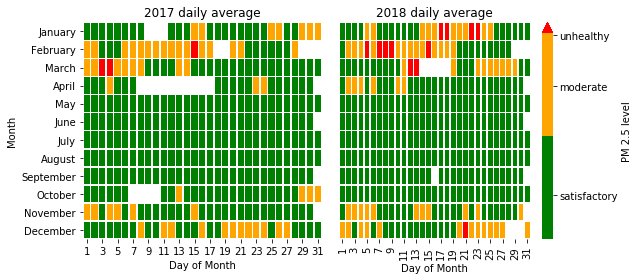

In [169]:
colors = ['green','orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

fig = plt.figure(figsize= (9,4))
ax1 = fig.add_subplot(121)
ax1 = sns.heatmap(date_month_2017, cmap=cmap, norm=norm, linewidth=0.5,vmax=70, cbar=False)
plt.title('2017 daily average')
plt.xlabel('Day of Month')

ax2 = fig.add_subplot(122)
ax2 = sns.heatmap(date_month_2018, cmap=cmap, norm=norm, linewidth=0.5,vmax=70)
plt.title('2018 daily average')
cbar = ax2.collections[0].colorbar
cbar.set_ticks([15, 45, 55])
cbar.set_ticklabels(['satisfactory', 'moderate', 'unhealthy'])
cbar.set_label('PM 2.5 level')
plt.xlabel('Day of Month')
ax2.get_yaxis().set_visible(False)
plt.tight_layout()

Text(0.5, 1.0, 'monthly average')

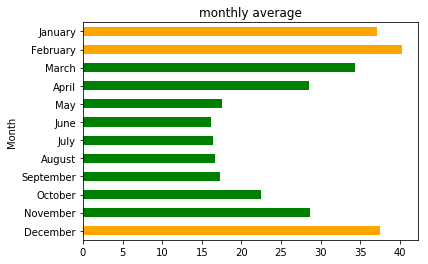

In [335]:
monthavg = pm25[['Month','PM2.5avg','color']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_name))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)
monthavg.plot(y='PM2.5avg', kind='barh',color = monthavg['color'], legend=False)

plt.title('monthly average')

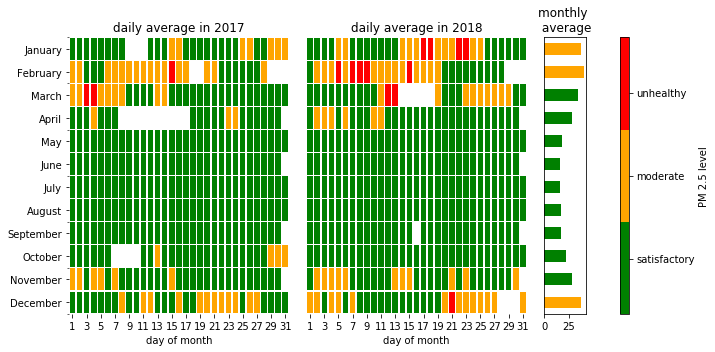

In [110]:
colors = ['green','orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

fig = plt.figure(figsize= (10,5))
gs = GridSpec(1,10)
ax1 = fig.add_subplot(gs[0:4])
sns.heatmap(date_month_2017, cmap=cmap, norm=norm, linewidth=0.5,vmax=70, cbar=False, ax=ax1)
ax1.yaxis.label.set_visible(False)

plt.title('daily average in 2017')
plt.xlabel('day of month')

ax2 = fig.add_subplot(gs[4:8],sharey =ax1)
ax2 = sns.heatmap(date_month_2018, cmap=cmap, norm=norm, linewidth=0.5,vmax=70, cbar=False)
plt.title('daily average in 2018')
plt.xlabel('day of month')
ax2.get_yaxis().set_visible(False)
#ax2.set_xticks(ax1.get_xticks())


ax3 = fig.add_subplot(gs[8])
monthavg = pm25[['Month','PM2.5avg']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_name))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)
monthavg.plot(y='PM2.5avg', kind='barh',color = monthavg['color'], legend=False, ax=ax3)
ax3.get_yaxis().set_visible(False)
plt.title('monthly \n average')

cmap2 = mpl.colors.ListedColormap(colors=['green','orange','red'])
ax4 = fig.add_subplot(gs[9])
ax4.set_aspect(30)
cbar = mpl.colorbar.ColorbarBase(cmap=cmap2, ax=ax4)
cbar.set_ticks([0.2, 0.5, 0.8])
cbar.set_ticklabels(['satisfactory', 'moderate', 'unhealthy'])
cbar.set_label('PM 2.5 level')

plt.tight_layout()

For both 2017 and 2018, the pollution starts around October and last until early March. So tourists should staying in Bangkok in these months. I know what you are thinking. "Hey, those are my holiday! Where else I can go? May suggest Phuket, and Samui Island? The south of Thailand has low AQI all year long. We will answer this question later. 

In [87]:
pm25_winter = pm25['2018-02']
pm25_winter.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color
Time,,,,,,,,,
2018-02-01 00:00:00,18.6,24.445833,2018,February,1,Thursday,00:00:00,satisfactory,green
2018-02-01 01:00:00,17.5,23.945833,2018,February,1,Thursday,01:00:00,satisfactory,green
2018-02-01 02:00:00,16.7,23.570833,2018,February,1,Thursday,02:00:00,satisfactory,green
2018-02-01 03:00:00,14.6,23.045833,2018,February,1,Thursday,03:00:00,satisfactory,green
2018-02-01 04:00:00,23.1,23.133333,2018,February,1,Thursday,04:00:00,satisfactory,green


In [88]:
date_time_map = pd.crosstab(pm25_winter['DayofWeek'],pm25_winter['TimeofDay'], pm25_winter['PM2.5avg'], aggfunc=np.mean)
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()
date_time_map = date_time_map.reindex(day_name)
date_time_map.columns = [int(column[:2]) for column in date_time_map.columns ]
date_time_map.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayofWeek,,,,,,,,,,,,,,,,,,,,,
Monday,44.295833,44.760417,45.240625,45.669792,45.933333,46.202083,46.604167,46.912500,47.011111,47.291667,...,46.645833,47.273958,47.329167,47.222917,52.098611,52.104167,51.986111,51.977778,51.701389,46.572917
Tuesday,46.283333,45.945833,49.776389,44.611458,43.536111,43.402083,42.721875,42.035417,41.353125,40.691667,...,37.426042,36.972917,36.561458,36.332292,36.102083,35.993750,35.938542,35.793750,35.671875,35.623958
Wednesday,35.537500,35.553125,35.892708,38.343056,38.758333,36.902083,37.364583,31.905556,38.758333,39.859375,...,38.837500,43.107292,43.772917,44.350000,36.306944,36.800000,37.175000,45.831250,46.578125,47.288542
Thursday,21.762500,39.286111,45.532292,45.663542,45.966667,54.919444,45.986458,46.118750,46.450000,55.890278,...,34.163889,34.254167,34.101389,45.435417,45.359375,45.482292,45.394792,45.475000,45.586458,45.615625
Friday,45.646875,45.546875,45.461458,45.420833,49.395833,44.873958,44.906250,44.826042,44.868750,44.720833,...,42.467708,42.042708,41.690625,41.488542,41.377083,41.287500,41.294792,41.401042,41.591667,41.806250


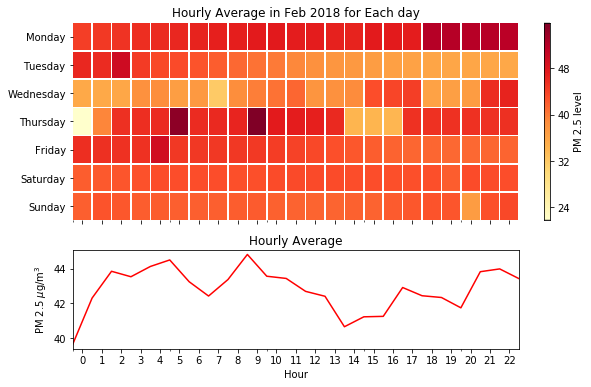

In [111]:
fig = plt.figure(figsize= (9,6))
gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[4, 2])


ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(date_time_map, cmap='YlOrRd', linewidth=0.5, cbar=False)
ax1.set_xlabel('Day of Week')
plt.title('Hourly Average in Feb 2018 for Each day')
ax1.yaxis.label.set_visible(False)

ax4 = fig.add_subplot(gs[1])
cbar = colorbar(ax1.get_children()[0], ax4)
ax4.set_ylabel('PM 2.5 level')
ax4.set_aspect(30)
plt.subplots_adjust(wspace=0)

ax2 = fig.add_subplot(gs[2], sharex=ax1)
#plt.bar(date_time_map.mean().index, height=date_time_map.mean().values)
date_time_map.mean().plot(ax=ax2, c='red')
plt.ylabel('PM 2.5 $\mu$g/m$^3$')
plt.xlabel('Hour');
plt.title('Hourly Average');
#plt.tight_layout()

What is the suggestion for the local Bangkokians? Is the morning Air or weekend better? What is the best time to go outside? Let's look at the hourly average in between Dec 2017 - Feb 2018.

In [150]:
#Select the time range
pm25_winter_2018 = pm25['2018-12':'2019-02']
#genrate table between average time of day and day of week
date_time_map = pd.crosstab(pm25_winter_2018['DayofWeek'],pm25_winter_2018['TimeofDay'], pm25_winter_2018['PM2.5avg'], aggfunc=np.mean)
#create string of Monday to Sunday
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()
#reindex to give index order 
date_time_map = date_time_map.reindex(day_name)
date_time_map.columns = [int(column[:2]) for column in date_time_map.columns.values ]
date_time_map.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayofWeek,,,,,,,,,,,,,,,,,,,,,
Monday,38.397917,38.834470,38.887121,38.911742,38.847727,40.005903,38.664394,38.547727,38.434848,38.375379,...,37.286667,37.136250,38.437500,38.388636,38.361742,38.328788,38.277273,38.220833,38.167803,38.189773
Tuesday,38.191667,39.219167,37.892045,35.173333,36.884259,39.072917,38.819167,38.559167,36.362500,36.226136,...,34.942803,34.640530,34.380682,34.105682,33.895455,33.711742,33.562121,34.463889,35.182500,35.097917
Wednesday,33.178409,32.990152,32.782955,32.587500,32.402273,32.295076,32.239015,32.277273,32.332955,32.510606,...,33.269697,33.304167,33.332197,33.433712,33.573864,33.804545,34.073485,34.335227,34.602652,34.764015
Thursday,34.902273,35.078409,35.266288,35.501136,35.701136,37.002083,34.576667,35.083796,35.942424,35.946970,...,35.779167,35.778030,36.710185,34.672685,34.609722,33.862917,35.605303,33.871250,36.014394,34.518333
Friday,35.315278,35.786111,36.272222,36.763426,36.785417,37.360417,38.298148,38.750926,38.311458,40.642187,...,40.720833,40.765741,40.857407,45.556548,43.598958,42.589583,42.618229,41.492593,41.568981,41.623611


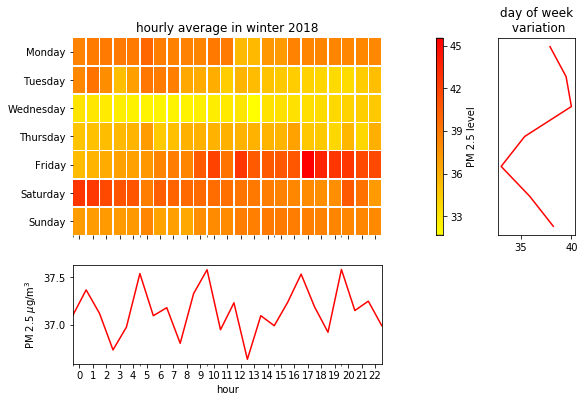

In [151]:
fig = plt.figure(figsize= (9,6))
gs = GridSpec(2, 3, width_ratios=[8, 3, 2], height_ratios=[4, 2])

#colors = ['green','orange','red']
#levels = [0, 35.4, 55.4]
#cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(date_time_map, cmap='autumn_r', linewidth=0.5, cbar=False)
plt.title('hourly average in winter 2018')
ax1.yaxis.label.set_visible(False)

ax4 = fig.add_subplot(gs[1])
cbar = colorbar(ax1.get_children()[0], ax4)
ax4.set_ylabel('PM 2.5 level')
ax4.set_aspect(30)
plt.subplots_adjust(wspace=0)

ax3 = fig.add_subplot(gs[2])
ax3.plot(date_time_map.mean(axis=1), day_name,c='red')
ax3.yaxis.set_visible(False)
plt.title('day of week\n variation')

ax2 = fig.add_subplot(gs[3], sharex=ax1)
#plt.bar(date_time_map.mean().index, height=date_time_map.mean().values)
date_time_map.mean().plot(ax=ax2, c='red')
plt.ylabel('PM 2.5 $\mu$g/m$^3$')
plt.xlabel('hour');
#plt.tight_layout()

Morning air is not better. The better time is in in the late afternoon. Weekend is not significantly better compared to the weekdays.

# Fitting

In [172]:
coeff, V = np.polyfit(pm25['Timedelta'], pm25['PM2.5'],1, cov=True)
p = np.poly1d(coeff)
y_pred = p(pm25['Timedelta'])

In [181]:
coeff, np.sqrt(np.diag(V))

(array([ 0.0001 , 24.13695]), array([0.00001, 0.1828 ]))

In [156]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 5 columns):
PM2.5        23667 non-null float64
TimeStamp    23667 non-null datetime64[ns, Asia/Bangkok]
PM2.5avg     23667 non-null float64
Timedelta    23667 non-null timedelta64[ns]
dayOfWeek    23667 non-null object
dtypes: datetime64[ns, Asia/Bangkok](1), float64(2), object(1), timedelta64[ns](1)
memory usage: 924.6+ KB


In [177]:
np.var(pm25['PM2.5'])/len(pm25)**2

3.5892524722261356e-07

In [229]:
pm25 = sm.add_constant(pm25)
est = sm.OLS(pm25['PM2.5avg'], sm.add_constant(pm25['Timedelta'])).fit()

In [230]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

prstd, iv_l, iv_u = wls_prediction_std(est)

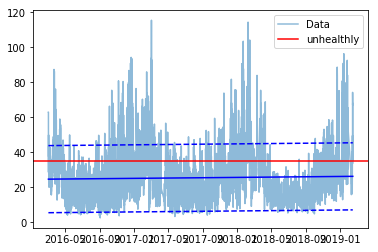

In [240]:
fig, ax = plt.subplots()
ax.plot(pm25['TimeStamp'], pm25['PM2.5'], label ='Data', alpha=0.5)
ax.plot(pm25['TimeStamp'], est.fittedvalues, 'b')
ax.plot(pm25['TimeStamp'], iv_l, 'b--')
ax.plot(pm25['TimeStamp'], iv_u, 'b--')
plt.axhline(y=35, color='r',label='unhealthly')
legend = ax.legend(loc="best")

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\seaborn\regression.py:223: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  X, y = np.c_[np.ones(len(self.x)), self.x], self.y


TypeError: invalid type promotion

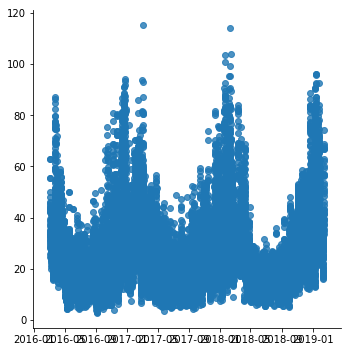

In [242]:
sns.lmplot(y='PM2.5', pm25['TimeStamp'].d, data=pm25) 

In [214]:
pm25['Timedelta'].shape

(23667,)

# Maps

1. Extract city name, region name and the lattitude and logtitude from all data files, and convert to Mercator system. 
2. Collect data from all files in a single DataFrame and save it
3. Get the names of all BKK neighbor province
4. Display the data on a map. I use tile from Stamen.
5. Build interactive plot for each months

## 1. Extract city name, region name and the lattitude and logtitude from all data files, and convert to Mercator system. 

I am going to use Bokeh geographical map, which use Mercator coordinate system. 

In [385]:
import re

In [443]:
#Extract geospatial data 
def geo_info(filename):
    with open(filename,'r') as f:
        data = f.read()
        city = re.search('City: (.+)', data).group(1)
        region = re.search('Region: (.+)', data).group(1)
        pop = re.search('Population: (\w+)', data).group(1)    
        lat = re.search('Latitude: (\d+.\d+)', data).group(1)
        lng = re.search('Longitude: (\d+.\d+)', data).group(1)  
    return [city, region, pop, lat, lng]


In [444]:
region_info = []
for filename in glob('data/*.txt'):
    info = geo_info(filename)
    region_info.append(info)
    

In [445]:
region_df = pd.DataFrame(region_info, columns=['City','Region', 'Population','Latitude','Longitude'])

In [635]:
region_df.head()

,City,Region,Population,Latitude,Longitude,x_mer,y_mer
0,Bangkok,Bangkok,5104476,13.7540,100.5014,1.118776e+07,1.649990e+06
1,Bang Kruai,Nonthaburi,78305,13.8050,100.4728,1.118458e+07,1.655825e+06
2,Ban Lam Luk Ka,Pathum Thani,60700,13.9774,100.7778,1.121853e+07,1.675559e+06
3,Ban Mai,Songkhla,86899,7.2041,100.5451,1.119263e+07,9.103199e+05
4,Ban Pong,Ratchaburi,57559,13.8163,99.8774,1.111830e+07,1.657118e+06


In [682]:
#from https://wiki.openstreetmap.org/wiki/Mercator
import math

def merc_x(lon):
  r_major = 6378137.000
  return r_major*math.radians(lon)

def merc_y(lat):
    lat += 0.08
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

In [683]:
region_df['x_mer']= region_df.Longitude.apply(merc_x)
region_df['y_mer']= region_df.Latitude.apply(merc_y)

In [649]:
region_df.describe(include='all')

,City,Region,Population,Latitude,Longitude,x_mer,y_mer
count,56,56,5.600000e+01,56.000000,56.000000,5.600000e+01,5.600000e+01
unique,56,41,NaN,NaN,NaN,NaN,NaN
top,Pak Kret,Nonthaburi,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.956620e+05,13.554377,100.738621,1.121417e+07,1.572554e+06
std,NaN,NaN,6.713606e+05,3.231692,1.311508,1.459965e+05,3.675895e+05
min,NaN,NaN,5.000000e+04,6.540000,98.398100,1.095363e+07,7.804353e+05
25%,NaN,NaN,5.834075e+04,12.677275,99.953025,1.112672e+07,1.470258e+06
50%,NaN,NaN,8.311300e+04,13.840150,100.524200,1.119030e+07,1.602694e+06
75%,NaN,NaN,1.237000e+05,15.731150,101.027775,1.124636e+07,1.819571e+06


In [453]:
region_df.query('Region == "Nonthaburi"')

,City,Region,Population,Latitude,Longitude
1,Bang Kruai,Nonthaburi,78305,13.805,100.4728
25,Mueang Nonthaburi,Nonthaburi,291555,13.8607,100.5148
31,Pak Kret,Nonthaburi,182926,13.913,100.4988


In [78]:
region_df['Region'] = region_df['Region'].str.replace('TH.S','Chonburi')
region_df['Region'] = region_df['Region'].str.replace('Changwat','')

In [79]:
region_df.to_csv('data/region_info.csv', index=False)

In [10]:
region_df = pd.read_csv('data/region_info.csv')

## 2. Collect data from all files in a single DataFrame and save it

In [454]:
def read_pm(filename):
    pm25 = pd.read_csv(filename, sep='\t', header=None, skiprows=10)
    #assemble datetime column 
    pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})
    #convert time zone
    pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
    pm25['Time'] = pm25['Time'].dt.tz_localize(None)
    pm25=pm25.drop([0,1,2,3,5,6],axis=1)
    pm25.columns = ['PM2.5', 'Time']
    
    city = geo_info(filename)[0]
    pm25['city'] = city
    
    return pm25

In [465]:
pm25_all = pd.DataFrame()
for filename in glob('data/*.txt'):
    pm25_region = read_pm(filename)
    pm25_all = pm25_all.append(pm25_region,ignore_index=True)


In [469]:
pm25_all.to_csv('data/pm25_all.csv', index=False)

In [20]:
pm25_all = pd.read_csv('data/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])

In [23]:
pm25_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249843 entries, 0 to 1249842
Data columns (total 3 columns):
PM2.5    1249843 non-null float64
Time     1249843 non-null datetime64[ns]
city     1249843 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.6+ MB


## 3. Get the names of all Bangkok neighbor provinces

In [383]:
# Obtain all province in BKK neighbors
bkk_nei = ['Bangkok']
with open('data/Bangkok.neighbors.json') as json_file:  
    data = json.load(json_file)
    for vec in data:
        bkk_nei.append(vec[1])

#remove province not in the proximity of BKK 
bkk_nei = bkk_nei[:8]

In [384]:
bkk_nei

['Bangkok',
 'Nonthaburi',
 'Samut_Prakan',
 'Samut_Sakhon',
 'Pathum_Thani',
 'Nakhon_Pathom',
 'Phra_Nakhon_Si_Ayutthaya',
 'Ratchaburi']

In [598]:
# load the region info and pm25 records
region_df = pd.read_csv('data/region_info.csv')

pm25_all = pd.read_csv('data/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all.set_index('Time',inplace=True)

## 4. Display the data on a map. 

I use tile from Stamen.

In [40]:
#pm25_all.set_index('Time', inplace=True)
pm25_all_jan19 = pm25_all['2019-01']

In [41]:
reg_monthavg = pm25_all_jan19.groupby('city', as_index=False).mean()
reg_monthavg = reg_monthavg.merge(region_df, left_on ='city', right_on='City').drop('city',axis=1)

In [42]:
reg_monthavg['level'] = pd.cut(reg_monthavg['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
reg_monthavg['size'] = [25 if x=='Bangkok' else 20 for x in reg_monthavg.City]

In [38]:
reg_monthavg.head(8)

,PM2.5,City,Region,Population,Latitude,Longitude,x_mer,y_mer,level,size
0,33.498706,Ban Lam Luk Ka,Pathum Thani,60700,13.9774,100.7778,1.121853e+07,1.570430e+06,satisfactory,20
1,11.950485,Ban Mai,Songkhla,86899,7.2041,100.5451,1.119263e+07,8.076416e+05,satisfactory,20
2,39.884466,Ban Pong,Ratchaburi,57559,13.8163,99.8774,1.111830e+07,1.552066e+06,moderate,20
3,16.423948,Ban Talat Yai,Phuket,52192,7.8848,98.4001,1.095385e+07,8.835903e+05,satisfactory,20
4,37.358900,Bang Kruai,Nonthaburi,78305,13.8050,100.4728,1.118458e+07,1.550779e+06,moderate,20
5,35.795146,Bangkok,Bangkok,5104476,13.7540,100.5014,1.118776e+07,1.544968e+06,moderate,25
6,30.250647,Chaiyaphum,Chaiyaphum,58350,15.8105,102.0288,1.135779e+07,1.780353e+06,satisfactory,20
7,23.726699,Chanthaburi,Chanthaburi,99819,12.6096,102.1045,1.136622e+07,1.414911e+06,satisfactory,20


In [19]:
from bokeh.io import output_file, output_notebook, show, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox


In [48]:
output_notebook()

Loading BokehJS ...

In [32]:
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 1E5
stepy = stepx

print(bkk_x,bkk_y,stepx,stepy)

11187764.672011103 1544967.9205643306 100000.0 100000.0


In [45]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(bkk_x-stepx,bkk_x+1.5*stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'PM 2.5 Pollution January 2019')
p.add_tile(STAMEN_TERRAIN)

source = ColumnDataSource(reg_monthavg)
color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                      palette=['green', 'orange', 'red'])

p.circle(source=source, x='x_mer',y='y_mer', size='size', alpha=0.7,
        color=dict(field='level',transform=color_mapper), legend='level')


show(p)

In [51]:
export_png(p,filename='bkk_jan2019.png')

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\bkk_jan2019.png'

## 5. Building interactive plot 
- Seasonal air pollution for the entire country
- which province has the highest air pollutions?
 

In [20]:
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot

In [13]:
region_df = pd.read_csv('data/region_info.csv')
pm25_all = pd.read_csv('data/pm25_all.csv').dropna()
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all.head()

,PM2.5,Time,city
0,62.9,2016-03-03 15:00:00,Bangkok
1,62.9,2016-03-03 16:00:00,Bangkok
2,55.5,2016-03-03 17:00:00,Bangkok
3,55.5,2016-03-03 18:00:00,Bangkok
4,47.9,2016-03-03 19:00:00,Bangkok


In [14]:
pm25_all['month'] = pm25_all['Time'].dt.to_period('M')
pm25_all['year'] = pm25_all['Time'].dt.to_period('Y')
pm25_all.head()

,PM2.5,Time,city,month,year
0,62.9,2016-03-03 15:00:00,Bangkok,2016-03,2016
1,62.9,2016-03-03 16:00:00,Bangkok,2016-03,2016
2,55.5,2016-03-03 17:00:00,Bangkok,2016-03,2016
3,55.5,2016-03-03 18:00:00,Bangkok,2016-03,2016
4,47.9,2016-03-03 19:00:00,Bangkok,2016-03,2016


In [80]:
monthly_all = pm25_all.groupby(['month','city'],as_index=False).mean()
#monthly_all['month'] = monthly_all['month'].values.astype('datetime64[M]')
monthly_all['city'] = monthly_all['city'].astype('category')
monthly_all = monthly_all.merge(region_df, left_on=['city'], right_on='City')
monthly_all['level'] = pd.cut(monthly_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
monthly_all = monthly_all.drop(['city','City','Population','Latitude','Longitude'],axis=1)
monthly_all.sort_values('y_mer',ascending=False,inplace=True)
monthly_all.tail()

,month,PM2.5,Region,x_mer,y_mer,level
1841,2019-02,17.980260,Yala,1.127458e+07,733657.663071,satisfactory
1840,2019-01,18.564031,Yala,1.127458e+07,733657.663071,satisfactory
1839,2018-12,14.292233,Yala,1.127458e+07,733657.663071,satisfactory
1838,2018-11,16.203863,Yala,1.127458e+07,733657.663071,satisfactory
1823,2017-08,16.498505,Yala,1.127458e+07,733657.663071,satisfactory


In [16]:
month_min = monthly_all['month'].min().strftime('%Y-%m')
month_max = monthly_all['month'].max().strftime('%Y-%m')
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 3E5
stepy = 3*stepx

In [21]:
reset_output()

In [22]:
output_notebook()

Loading BokehJS ...

In [23]:
def plot_monthly(doc):

    p = figure(x_range=(bkk_x-0.3*stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator",
               title='PM 2.5 Pollution', plot_width=450, plot_height=600)
    p.add_tile(STAMEN_TERRAIN)

    source = ColumnDataSource(monthly_all[monthly_all['month'] == '2019-03'])
    color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                          palette=['green', 'orange', 'red'])

    r = p.circle(source=source, x='x_mer', y='y_mer', size=15, alpha=0.7,
                 color=dict(field='level', transform=color_mapper))
    
    legend = Legend(items=[LegendItem(label=dict(field='level'), renderers=[r])], location="bottom_right")

    
    p.add_layout(legend)

    p2 = figure(y_range=monthly_all['Region'].iloc[::-1].unique(), x_range=(0, 70),
                plot_width=200, plot_height=600, toolbar_location=None)

    p2.xaxis.major_label_orientation = math.pi/2
    p2.xaxis.ticker = [0, 20, 40, 60]

    p2.hbar(y='Region', right='PM2.5', height=0.5, source=source,
            color=dict(field='level', transform=color_mapper))

    def callback(attr, old, new):
        data = monthly_all[monthly_all['month'] == new]
        source.data = ColumnDataSource(data=data).data

    slider = DateSlider(title='Month of Year', start=month_min, end=month_max, step=1,
                        value=month_min, format='%B %Y')
    slider.on_change('value', callback)

    layout = column(widgetbox(slider), row(p2, p))
    doc.add_root(layout)

In [27]:
show(plot_monthly)

In [51]:
def show_monthly(monthly_all, month):

    p = figure(x_range=(bkk_x-0.3*stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator",
               title='PM 2.5 Pollution in '+month.strftime('%B %Y'), plot_width=450, plot_height=600)
    p.add_tile(STAMEN_TERRAIN)

    source = ColumnDataSource(monthly_all[monthly_all['month'] == month])
    color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                          palette=['green', 'orange', 'red'])

    r = p.circle(source=source, x='x_mer', y='y_mer', size=15, alpha=0.7,
                 color=dict(field='level', transform=color_mapper))
    
    legend = Legend(items=[LegendItem(label=dict(field='level'), renderers=[r])], location="bottom_right")

    
    p.add_layout(legend)

    p2 = figure(y_range=monthly_all['Region'].iloc[::-1].unique(), x_range=(0, 70),
                plot_width=200, plot_height=600, toolbar_location=None)

    p2.xaxis.major_label_orientation = math.pi/2
    p2.xaxis.ticker = [0, 20, 40, 60]

    p2.hbar(y='Region', right='PM2.5', height=0.5, source=source,
            color=dict(field='level', transform=color_mapper))

    layout = row(p2, p)
    month = month.strftime('%Y-%m')
    export_png(layout,filename='monthly_map/'+month+'monthly_map.png')

In [52]:
for month in monthly_all['month'].unique():
    show_monthly(monthly_all, month)

In [40]:
from glob import glob
import imageio

In [53]:
filenames = glob('monthly_map/*.png')

In [59]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('monthly_map/monthly_map.gif', images, duration=0.2)

In [83]:
yearly_all = pm25_all.groupby(['year','city'], as_index=False).max()
yearly_all['year'] = yearly_all['year'].values.astype(str)
yearly_all['city'] = yearly_all['city'].astype('category')
yearly_all = yearly_all.merge(region_df,left_on='city',right_on='City')
yearly_all['level'] = pd.cut(yearly_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
yearly_all = yearly_all.drop(['city','Population','Latitude','Longitude','City'],axis=1)

# drop the value in 2016 and 2019 due to incomplete data 
yearly_all = yearly_all.drop(yearly_all.loc[yearly_all['year'].isin(['2016','2019'])].index)
yearly_all.sort_values('PM2.5',ascending=False,inplace=True)
yearly_all.reset_index(inplace=True)
yearly_all.tail()

,index,year,PM2.5,Time,month,Region,x_mer,y_mer,level
106,45,2017,59.2,2017-12-31 23:00:00,2017-12,Chumphon,1.104063e+07,1.176187e+06,unhealthy
107,6,2018,59.2,2018-12-31 23:00:00,2018-12,Songkhla,1.119263e+07,8.076416e+05,unhealthy
108,118,2018,58.3,2018-12-31 23:00:00,2018-12,Nakhon Si Thammarat,1.112824e+07,9.448815e+05,unhealthy
109,205,2017,52.8,2017-12-31 23:00:00,2017-12,Trang,1.108869e+07,8.469228e+05,moderate
110,206,2018,44.8,2018-12-31 23:00:00,2018-12,Trang,1.108869e+07,8.469228e+05,moderate


In [85]:
monthly_all['year'] = monthly_all['month'].dt.strftime('%Y')
yearly_all = monthly_all.groupby(['year','Region'], as_index=False).max()
yearly_all.sort_values('PM2.5',ascending=False,inplace=True)

# drop the value in 2016 and 2019 due to incomplete data 
yearly_all = yearly_all.drop(yearly_all.loc[yearly_all['year'].isin(['2016','2019'])].index)

yearly_all.tail()

,year,Region,PM2.5,month,x_mer,y_mer
59,2017,Nakhon Si Thammarat,22.758319,2017-12,1.112824e+07,944881.495734
77,2017,Trang,22.458169,2017-12,1.108869e+07,846922.840036
118,2018,Trang,21.950633,2018-12,1.108869e+07,846922.840036
66,2017,Phuket,21.274390,2017-12,1.095385e+07,884237.988691
115,2018,Songkhla,21.247627,2018-12,1.119820e+07,807641.616273


In [95]:
yearly_all = yearly_all[yearly_all['Region']!='Ubon Ratchathani']

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


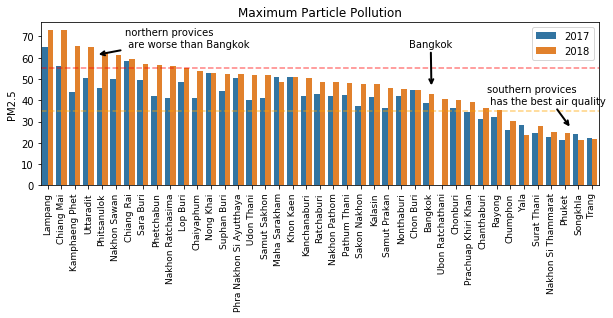

In [98]:
f = plt.figure(figsize=(10,3))

plt.axhline(55, color='red', alpha=0.5, linestyle='--')
plt.axhline(35, color='orange', alpha=0.5,linestyle='--')

g = sns.barplot(x="Region", y="PM2.5", hue='year', data=yearly_all)
plt.legend(loc= 'upper right')
plt.xticks(rotation=90, fontsize=9)
ax1 = plt.axes()
ax1.xaxis.label.set_visible(False)

plt.annotate('southern provices\n has the best air quality',xycoords='axes fraction',
              textcoords='axes fraction',
             xy = (0.95,0.35), xytext=(0.8,0.5), arrowprops=dict(arrowstyle='->', lw = 2))

plt.annotate('northern provices\n are worse than Bangkok',xycoords='axes fraction',
              textcoords='axes fraction',
             xy = (0.1,0.8), xytext=(0.15,0.85), arrowprops=dict(arrowstyle='->', lw = 2))

plt.annotate('Bangkok',xycoords='axes fraction',xy = (0.7,0.6),
            textcoords='axes fraction', xytext=(0.66,0.85),
            arrowprops=dict(arrowstyle='->', lw = 2))
plt.title('Maximum Particle Pollution')
plt.show(g)

In [309]:


p2 = figure(y_range=monthly_all['City'].unique(), 
                plot_width=200, plot_height=600,toolbar_location=None)
source = ColumnDataSource(monthly_all[monthly_all['month'] == '2019-03'])
    
p2.hbar(y='City',right= 'PM2.5', height=0.5, source=source)


show(p2)